# Part 1

In [1]:
#importing necessary libraries
from itertools import product
from math import sqrt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.integrate import odeint


### Importing Data, EDA and Data Manipulation

In [2]:
##Data is imported as dataframe
states = pd.read_csv("us-states.csv")


In [3]:
##Filtering out texas
Nebraska_index = states["state"] == 'Nebraska'
Nebraska = states[Nebraska_index]

Text(0, 0.5, 'Case Count')

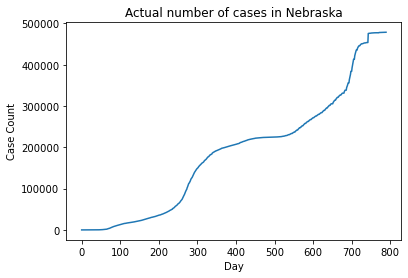

In [4]:
##Trend of cummulative cases
t = np.linspace(0, 789, 789)
plt.plot(t, Nebraska["cases"])
plt.title("Actual number of cases in Nebraska")
plt.xlabel("Day")
plt.ylabel("Case Count")

In [5]:
t = np.linspace(0, 789, 789)

#I[t] is the number of cases per day/true outcome
I =  []
for count in Nebraska["cases"]:
    I.append(count)
    
#N: total population - taken from https://www.census.gov/quickfacts/TX
N = 1934000


<ipython-input-6-1c5ff1f05a56>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nebraska["infected"] = Nebraska["cases"] - x


Text(0, 0.5, 'Fraction of Population')

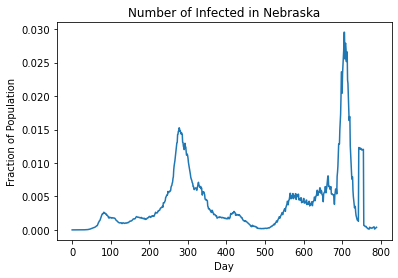

In [6]:
## Trend to see how I is changing to calibrate the values of 
x = list(Nebraska["cases"])
for i in range(0,13):
    x.insert(0,0)
x = x[:-13]
Nebraska["infected"] = Nebraska["cases"] - x
plt.plot(t, Nebraska["infected"]/N)
plt.title("Number of Infected in Nebraska")
plt.xlabel("Day")
plt.ylabel("Fraction of Population")

In [7]:
#parts of code taken from SIR.Extensions.ipynb from Canvas

#number of infected people and recovered people initially
#using same values as code. Assuming not very many people were infected in Texas, since outbreak started in Washington state
I0 = 1

#formula for estimating R0 taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7751056/
        #  R0 = I[t] * SI / t , were SI is the time between the first and second COVID case
        #second covid case data from 
R0 = 0

#number  of people who are initially susceptible
S0 = N - I0 - R0 

# Initial vector
y0 = S0, I0, R0

# average recovery time is 2 weeks 
gamma = 1/14

### SIR Model

In [8]:
#code taken from SIR.Extensions.ipynb from Canvas
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [9]:
#code below taken from SIR.Extensions.ipynb from Canvas
#x0 = major outbreak occurs (state of emergency) = March 12

#data looked at: https://www.worldometers.info/coronavirus/usa/texas/
epochs = [0, 85, 270, 330, 550, 580, 670, 730]
R_0 = [2.33, 1, 1.73, 0.4, 1.1, 1.76, 1.1, 1.9, 0.04]
k = [0.3, 0.13, 0.02, 0.08, 0.1, 0.9, 0.1, 0.1]
x = [90, 230, 310, 360, 540, 570, 650, 720]


def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k[i], x[i], R_0[i],  R_0[i+1])
    return value

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma
def root_mean_square_error(x,y):
    total = 0
    N = len(x)
    for i in range(len(x)):
        dif = x[i] - y[i]
        total = total + (dif**2)
    return sqrt(total/N)
     
def mean_absolute_error(x,y):
    total = 0
    N = len(x)
    for i in range(len(x)):
        dif = x[i] - y[i]
        total = total + abs(dif)
    return total/N

In [10]:
def root_mean_square_error(x,y):
    total = 0
    N = len(x)
    for i in range(len(x)):
        dif = x[i] - y[i]
        total = total + (dif**2)
    return sqrt(total/N)
     

In [11]:
def mean_absolute_error(x,y):
    total = 0
    N = len(x)
    for i in range(len(x)):
        dif = x[i] - y[i]
        total = total + abs(dif)
    return total/N

In [12]:
#code taken from SIR.Extensions.ipynb from Canvas
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T


### Results from the SIR model and Errors

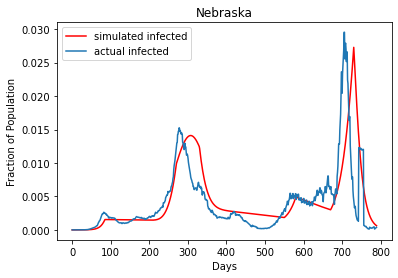

In [13]:
plt.figure(facecolor = 'w')
plt.plot(t, I/N, 'r', label = "simulated infected")
plt.plot(t, Nebraska["infected"]/N, label = "actual infected")

plt.xlabel("Days")
plt.ylabel("Fraction of Population")
plt.title("Nebraska")
plt.legend()



### root mean square error

In [14]:
actual_I = list(Nebraska["infected"])
simulated_I = I 
print("The root mean square error is:", round(root_mean_square_error(actual_I, simulated_I),1))
print("The mean absolute error is:", round(mean_absolute_error(actual_I, simulated_I)),2)

The root mean square error is: 7971.1
The mean absolute error is: 4172 2


# Part 2

## Plotting changes in R0

In [15]:
#cite: data from https://www.healthdata.org/covid/data-downloads

##Loading 2 years of data as a dataframe
df2020=pd.read_csv('data_download_file_reference_2020.csv')
df2021=pd.read_csv('data_download_file_reference_2021.csv')
df2022=pd.read_csv('data_download_file_reference_2022.csv')

In [16]:
##Creating a master dataframe containing all 3 years of data
df20_21=df2020.append(df2021)
df_covid=df20_21.append(df2022)

In [17]:
##Retriving the columns required.
df_covid=df_covid.loc[:,['date','location_name','daily_deaths','cumulative_deaths', 'daily_cases','daily_deaths',
               'cumulative_cases', 'cumulative_hospitalizations','population','mobility_mean', 
               'testing_mean','pneumonia_mean','mask_use_mean','cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated']]

In [18]:
##Retriving values for Texas 
df_covid_Nebraska=df_covid[df_covid['location_name'] == 'Nebraska']
df_covid_Nebraska.reset_index(inplace=True,drop=True)


In [19]:
##Using the values of our R0 from SIR model we are calculating our dynamic R0 for all t
t_new = np.linspace(0, len(df_covid_Nebraska)-1, len(df_covid_Nebraska))
epochs = [0, 85, 270, 330, 550, 580, 670, 730]
R_0 = [2.33, 1, 1.73, 0.4, 1.1, 1.76, 1.1, 1.9, 0.04]
k = [0.3, 0.13, 0.02, 0.08, 0.1, 0.9, 0.1, 0.1]
x = [90, 230, 310, 360, 540, 570, 650, 720]

r_0_finals=[]
for i in t_new:
    r_0_finals.append(R_0_dynamic(i))


Text(0.5, 1.0, 'Mask vs Reproduction Number-Nebraska')

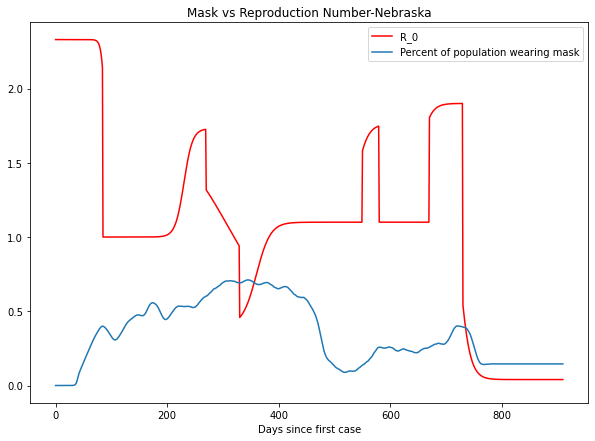

In [20]:
## Comparing masking with R0
plt.figure(figsize=(10, 7))
plt.plot(t_new,r_0_finals,label='R_0',color='r')
plt.plot(t_new,df_covid_Nebraska['mask_use_mean'],label='Percent of population wearing mask')
plt.legend()
plt.xlabel("Days since first case")
plt.title("Mask vs Reproduction Number-Nebraska")


Text(0.5, 1.0, 'Mask vs Infection')

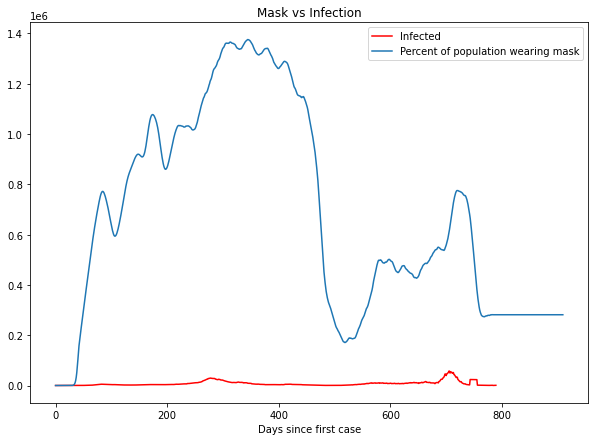

In [21]:
## Comparing masking with Infected
plt.figure(figsize=(10, 7))
plt.plot(t,Nebraska['infected'],label='Infected',color='r')
plt.plot(t_new,df_covid_Nebraska['mask_use_mean']*N,label='Percent of population wearing mask')
plt.legend()
plt.xlabel("Days since first case")
plt.title("Mask vs Infection")

Text(0.5, 1.0, 'Vaccination vs Reproduction Number Nebraska')

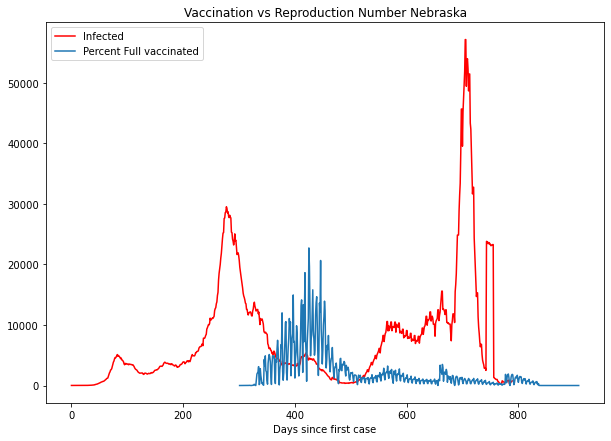

In [22]:
##Calculating daily vaccination and its trend with infected
new_vacc=[]
for i in range(1,len(df_covid_Nebraska['cumulative_all_fully_vaccinated'])):
    new_vacc.append(df_covid_Nebraska['cumulative_all_fully_vaccinated'][i]-df_covid_Nebraska['cumulative_all_fully_vaccinated'][i-1])
plt.figure(figsize=(10, 7))
t_new1 = np.linspace(0, len(new_vacc)-1, len(new_vacc))
plt.plot(t,Nebraska['infected'],label='Infected',color='r')
plt.plot(t_new1,np.array(new_vacc),label='Percent Full vaccinated')
plt.legend()

plt.xlabel("Days since first case")
plt.title("Vaccination vs Reproduction Number Nebraska")

Text(0.5, 1.0, 'Testing Nebraska')

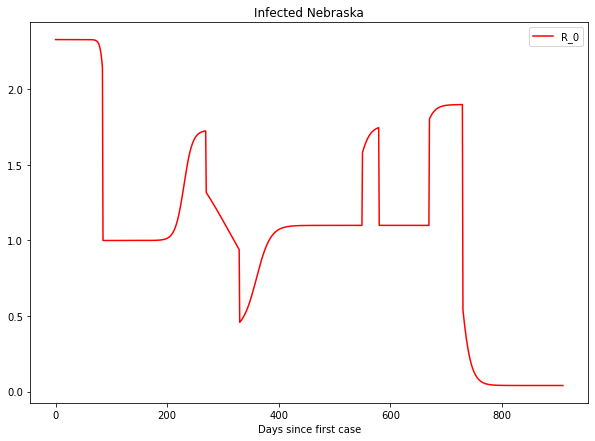

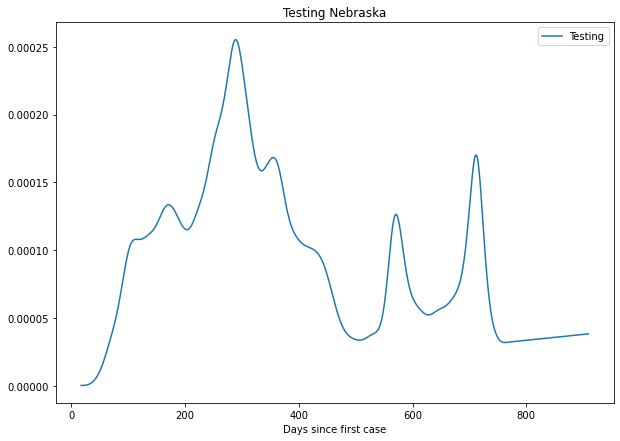

In [23]:
##Comparing R0 and testing
plt.figure(figsize=(10, 7))
plt.plot(t_new,r_0_finals,label='R_0',color='r')
plt.legend()
plt.xlabel("Days since first case")
plt.title("Infected Nebraska")
plt.figure(figsize=(10, 7))
plt.plot(t_new,df_covid_Nebraska['testing_mean']/df_covid_Nebraska['population'],label='Testing')
plt.legend()
plt.xlabel("Days since first case")
plt.title("Testing Nebraska")

Text(0.5, 1.0, 'Vaccination vs Cummulative cases')

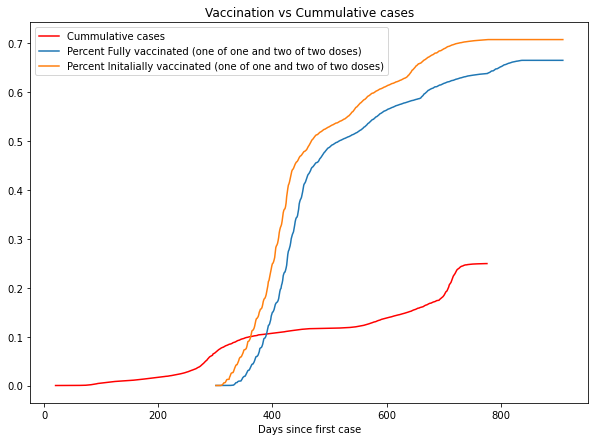

In [24]:
##Cummulative Vaccination with infection
plt.figure(figsize=(10, 7))
plt.plot(t_new,df_covid_Nebraska['cumulative_cases']/df_covid_Nebraska['population'],label='Cummulative cases',color='r')
plt.plot(t_new,df_covid_Nebraska['cumulative_all_fully_vaccinated']/df_covid_Nebraska['population'],label='Percent Fully vaccinated (one of one and two of two doses)')
plt.plot(t_new,df_covid_Nebraska['cumulative_all_vaccinated']/df_covid_Nebraska['population'],label='Percent Initalially vaccinated (one of one and two of two doses)')
plt.legend()
plt.xlabel("Days since first case")
plt.title("Vaccination vs Cummulative cases")


Text(0.5, 1.0, '%Change in Mobility  vs Reproduction Number-Nebraska')

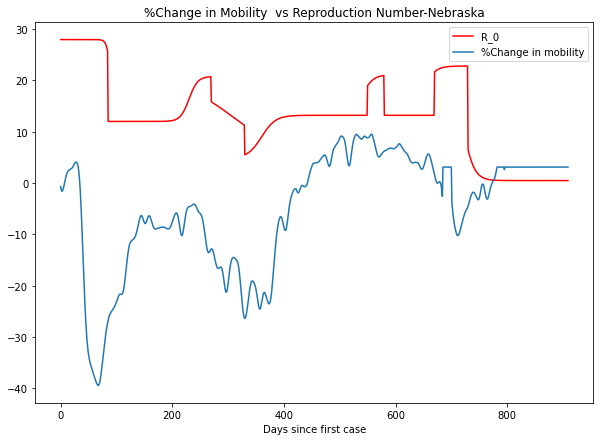

In [25]:
##Comparing mobility with R0
plt.figure(figsize=(10, 7))
r_0_scale=[12 * r for r in r_0_finals]
plt.plot(t_new,r_0_scale,label='R_0',color='r')
plt.plot(t_new,df_covid_Nebraska['mobility_mean'],label='%Change in mobility')
plt.legend()
plt.xlabel("Days since first case")
plt.title("%Change in Mobility  vs Reproduction Number-Nebraska")